In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, event
import urllib.parse
import time

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import seaborn as sns 
sns.set(rc={'figure.figsize':(18,18)})

# Inputs

In [2]:
#SQL
server = 'CSKMA0400\RDB_Data'
db = 'JLDJobPath'
odbc_connection_string = 'DRIVER={SQL Server Native Client 11.0};SERVER='+server+';DATABASE='+db+';Trusted_Connection=yes'

# Tables containing the datasets to model

sql_table_0 = "linkedclaims_casuals_2018m04_v2_flat_multi_with_income" # MM will be build using this data
sql_table_1 = "linkedclaims_casuals_2018m04_v2_flat_20140101_with_income" # MM will be build using this data
sql_table_2 = "linkedclaims_casuals_2018m04_v2_flat_20140401_with_income" # MM will be applied to this data
sql_table_3 = "linkedclaims_casuals_2018m04_v2_flat_20140701_with_income" # MM will be applied to this data
sql_table_4 = "linkedclaims_casuals_2018m04_v2_flat_20141001_with_income" # MM will be applied to this data
sql_table_5 = "linkedclaims_casuals_2018m04_v2_flat_20150101_with_income" # MM will be applied to this data
sql_table_6 = "linkedclaims_casuals_2018m04_v2_flat_20150401_with_income" # MM will be applied to this data
sql_table_7 = "linkedclaims_casuals_2018m04_v2_flat_20150701_with_income" # MM will be applied to this data
sql_table_8 = "linkedclaims_casuals_2018m04_v2_flat_20151001_with_income" # MM will be applied to this data
sql_table_9 = "linkedclaims_casuals_2018m04_v2_flat_20160101_with_income" # MM will be applied to this data
sql_table_10 = "linkedclaims_casuals_2018m04_v2_flat_20160401_with_income" # MM will be applied to this data
sql_table_11 = "linkedclaims_casuals_2018m04_v2_flat_20160701_with_income" # MM will be applied to this data
sql_table_12 = "linkedclaims_casuals_2018m04_v2_flat_20161001_with_income" # MM will be applied to this data
sql_tables_all = [sql_table_0, 
                  sql_table_1, 
                  sql_table_2,
                  sql_table_3,
                  sql_table_4,
                  sql_table_5,
                  sql_table_6,
                  sql_table_7,
                  sql_table_8,
                  sql_table_9,
                  sql_table_10,
                  sql_table_11,
                  sql_table_12] # list of all dataset provided

varprofile_csvfilename = "D:/DATA/linkedclaims_casuals_2018m04_v2_flat_20140101_with_income_with_edu_variable_profile.csv"


# Set to TRUE if you want to 
# normalise variables counting levels with name starting with 'total_duration_days_'
# by variable 'total_duration_days' -- Note: make sure the variables are selected in the variable profile csv file
do_normalize_total_day_counts = True
drop_normalisation_column = True

# Set to TRUE if you want to 
# sum columns and update accordingly the list of lists below, 
# eg Col_A + Col_B and Col_B + Col_C + Col_D: [[Col_A, Col_B], [Col_B, Col_C, Col_D]]
do_sum_columns = False
columns_to_sum = [['Class_A_Earn0','Class_S_Earn0','Class_Other_Earn0'],
                  ['Class_A_Earn1','Class_S_Earn1','Class_Other_Earn1'],
                  ['Class_A_Earn2','Class_S_Earn2','Class_Other_Earn2'],
                  ['Class_A_Earn3','Class_S_Earn3','Class_Other_Earn3'],
                  ['Class_A_Earn4','Class_S_Earn4','Class_Other_Earn4']
                  ]
drop_original_cols = False # Set this to TRUE if you want to drop the cols summed

# Set to TRUE if you want to 
# divide columns and update accordingly the list of lists below, 
# eg Col_A/Col_B and Col_B/Col_C/Col_D: [[Col_A, Col_B], [Col_B, Col_C, Col_D]]
do_divide_columns = True
columns_to_divide = [['Class_A_Earn0','Class_A_weeks0'], 
                     ['Class_A_Earn1','Class_A_weeks1'],
                     ['Class_A_Earn2','Class_A_weeks2'],
                     ['Class_A_Earn3','Class_A_weeks3'], 
                     ['Class_A_Earn4','Class_A_weeks4']]
drop_nominator = True     # Set to TRUE if you want to drop the nominator cols
drop_denominator = False  # Set to TRUE if you want to drop the denominator cols

# Set to TRUE if you want to apply Dirichelet Prior
do_dirichlet_prior = True
do_clip_to_zero = True

use_bayesian_mixtures = True # if false Gaussian Mixture Models are used
use_full_covariance = True # if false diagonal covariance is used
n_clusters = 7

show_plots = True

# Procedure

Processing data from linkedclaims_casuals_2018m04_v2_flat_multi_with_income
Reading data from SQL
Selecting Variables and filling na
Normalising total_day_counts
Dividing Columns
List of Variables:
['End_weekly_rate_0', 'LM_code_rank_0', 'age', 'duration_days_0', 'sex', 'total_duration_days_nat_code_Irish', 'total_max_LM_code_rank', 'total_max_ada_code_rank', 'total_max_family_flag_rank', 'total_max_marital_status_rank', 'total_max_occupation_rank', 'total_min_LM_code_rank', 'total_min_ada_code_rank', 'total_min_family_flag_rank', 'total_min_marital_status_rank', 'total_min_occupation_rank', 'Class_S_Earn0', 'Class_S_Earn1', 'Class_S_Earn2', 'Class_S_Earn3', 'Class_S_Earn4', 'Class_Other_Earn0', 'Class_Other_Earn1', 'Class_Other_Earn2', 'Class_Other_Earn3', 'Class_Other_Earn4', 'Class_A_weeks0', 'Class_A_weeks1', 'Class_A_weeks2', 'Class_A_weeks3', 'Class_A_weeks4', 'Class_A_Earn0/Class_A_weeks0', 'Class_A_Earn1/Class_A_weeks1', 'Class_A_Earn2/Class_A_weeks2', 'Class_A_Earn3/Class_A_we

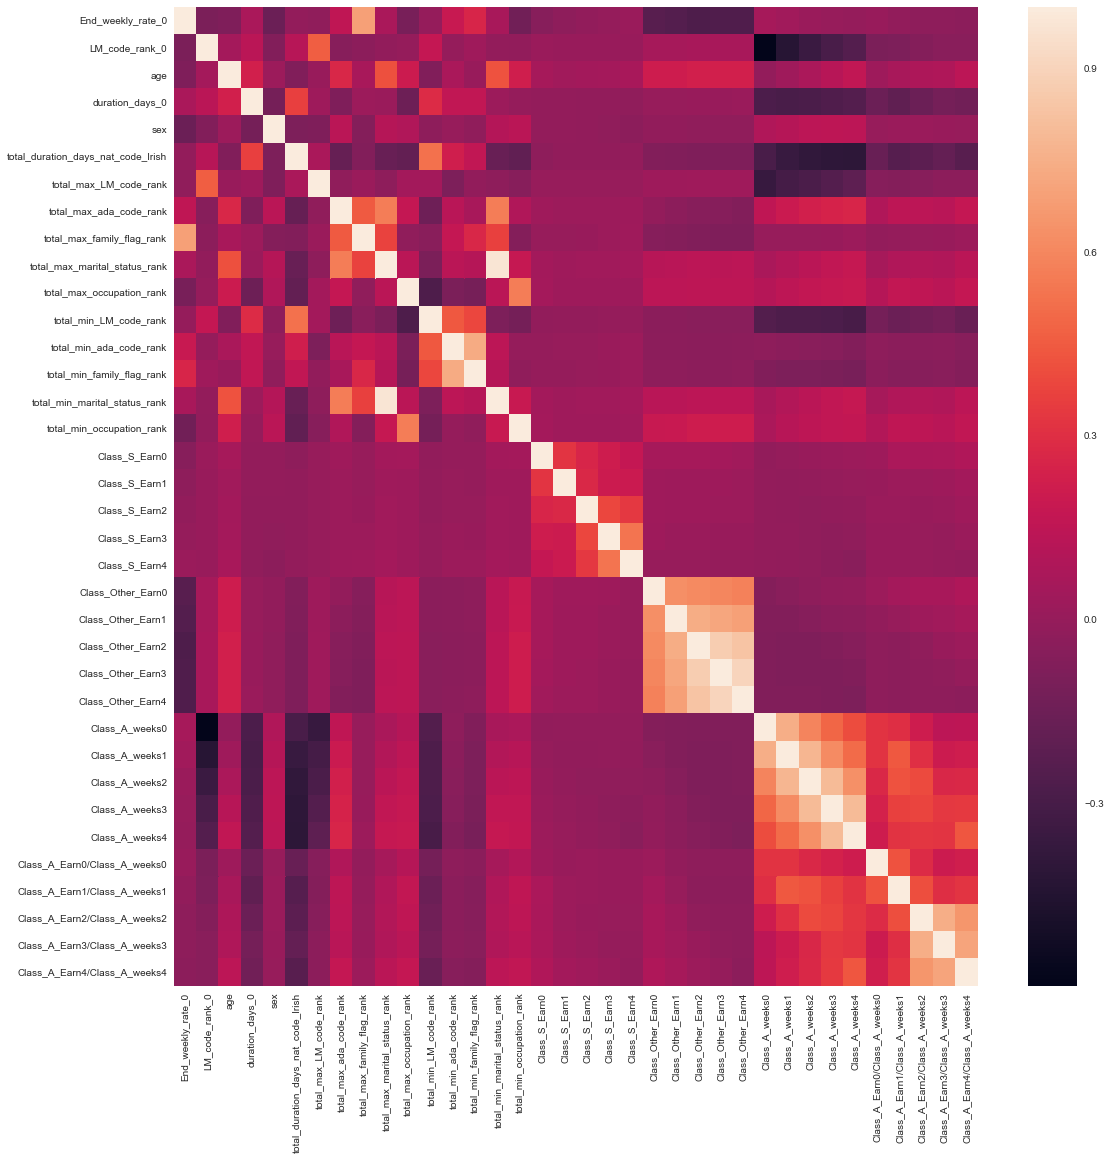

PCA Scatterplot


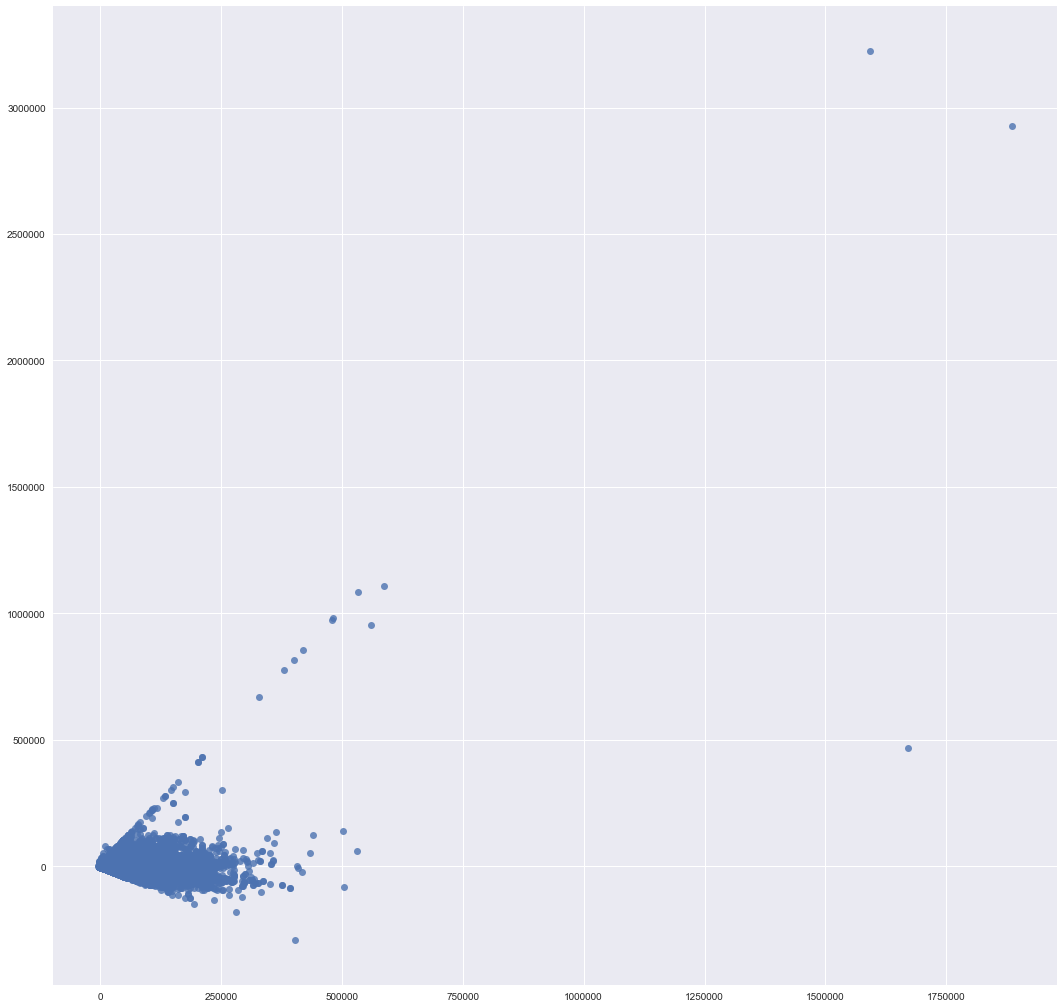

Applying Dirichlet Prior
Correlation Matrix


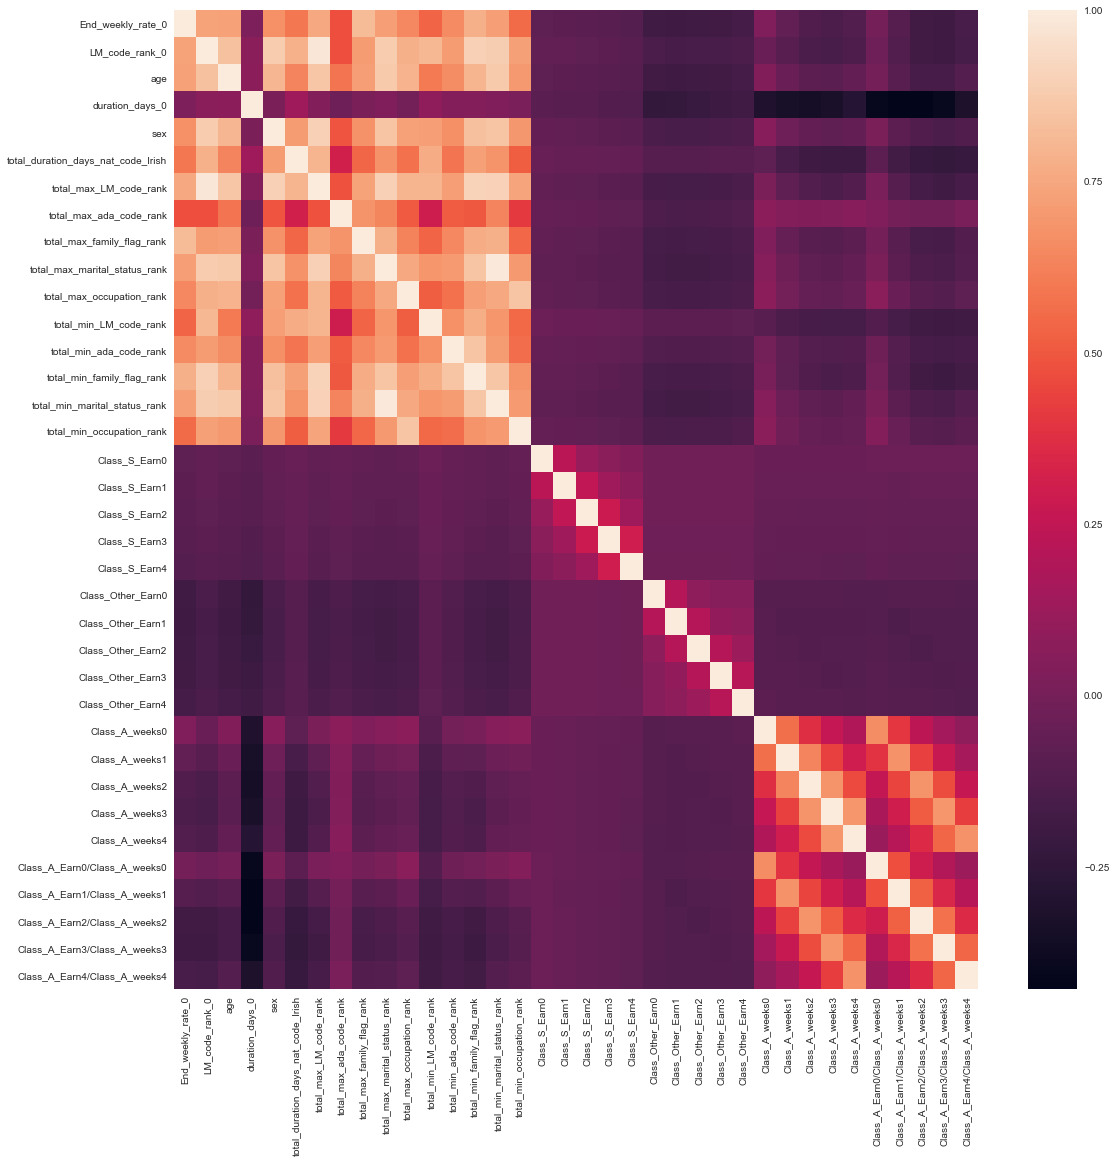

PCA Scatterplot


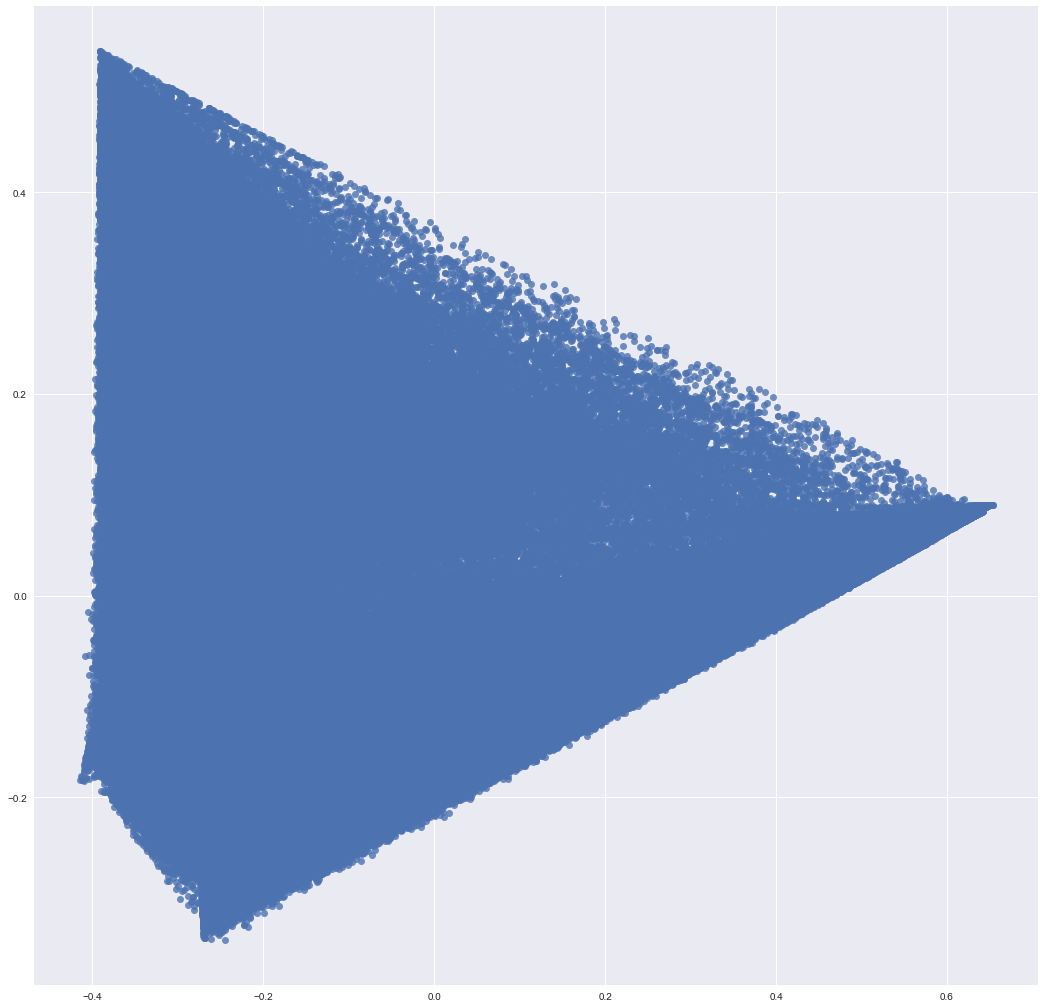

Build Mixture Models


C:\Users\MarcoGrimaldi\anaconda3\lib\site-packages\sklearn\mixture\base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)



Processing data from linkedclaims_casuals_2018m04_v2_flat_20140101_with_income
Reading data from SQL
Selecting Variables and filling na
Normalising total_day_counts
Dividing Columns
Applying Dirichlet Prior
Apply Mixture Models

Uploading to SQL cluster table: linkedclaims_casuals_2018m04_v2_flat_20140101_with_income_36Vars__7BGM_full_clusters
	Upload time: 00:00:17

Processing data from linkedclaims_casuals_2018m04_v2_flat_20140401_with_income
Reading data from SQL
Selecting Variables and filling na
Normalising total_day_counts
Dividing Columns
Applying Dirichlet Prior
Apply Mixture Models

Uploading to SQL cluster table: linkedclaims_casuals_2018m04_v2_flat_20140401_with_income_36Vars__7BGM_full_clusters
	Upload time: 00:00:13

Processing data from linkedclaims_casuals_2018m04_v2_flat_20140701_with_income
Reading data from SQL
Selecting Variables and filling na
Normalising total_day_counts
Dividing Columns
Applying Dirichlet Prior
Apply Mixture Models

Uploading to SQL cluster table

In [3]:
def read_data_from_sql(sql_table):
    # Connect to SQL
    params = urllib.parse.quote_plus(odbc_connection_string)
    engine = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)
    conn = engine.connect().connection

    @event.listens_for(engine, 'before_cursor_execute')
    def receive_before_cursor_execute(conn, cursor, statement, params, context, executemany):
        if executemany:
            cursor.fast_executemany = True

    df = pd.read_sql_table(sql_table, engine)
    conn.close()
    return df

def select_variables_fillna(df, do_one_hot_coding = False):
    features = pd.read_csv(varprofile_csvfilename)

    # Select variables based on stats feature selection
    var_sel = features[features.selected==1].Variable.tolist()
    ppsns = df['ppsn']
    df = df[var_sel].copy()

    # # filling NA with 0
    df.fillna(0, inplace=True)

    # One-hot coding on varchar variables
    if do_one_hot_coding:
        varchar = features.loc[((features.selected==1) & (features.Type=='Char')),:].Variable.tolist()
        df = pd.get_dummies(df, columns = varchar ) 
        
    if do_clip_to_zero:
        df = df.clip(lower=0)
    
    return df, ppsns

def normalize_total_day_counts(df, drop_norm_col = False):
    col_names = df.columns.tolist()
    name_needle = 'total_duration_days_'
    norm_col = 'total_duration_days'

    for col in col_names:
        if name_needle in col:
            df[col] = df[col] / (df[norm_col]+1)
    
    if drop_norm_col == True:
        df.drop(columns=[norm_col], inplace=True)
    return df

def sum_columns(df, columns_to_sum, drop_original_cols = False):
    for columns in columns_to_sum:
        cols_in_dataset = True
        for col in columns:
            if col not in df.columns.tolist():
                cols_in_dataset = False
        if cols_in_dataset:
            myname = '+'.join(columns)
            df[myname] = df[columns[0]]
            for i in range(1, len(columns)):
                df[myname] = df[myname] + df[columns[i]]
    if drop_original_cols:
        to_drop = []
        for columns in columns_to_sum:
            for col in columns:
                to_drop.append(col)
        df.drop(columns=to_drop, inplace=True)

def divide_columns(df, columns_to_divide, drop_nominator = True, drop_denominator = False):
    for columns in columns_to_divide:
        cols_in_dataset = True
        for col in columns:
            if col not in df.columns.tolist():
                cols_in_dataset = False
        if cols_in_dataset:
            myname = '/'.join(columns)
            df[myname] = df[columns[0]]
            for i in range(1, len(columns)):
                df[myname] = df[myname] / (df[columns[i]] +1)
    
    cols_to_drop = []
    if drop_nominator:
        for cols in columns_to_divide:
            cols_to_drop.append(cols[0])
    if drop_denominator:
        for cols in columns_to_divide:
            cols_to_drop.append(cols[1])
    if len(cols_to_drop) > 0:
        df.drop(columns=cols_to_drop, inplace=True)
        
        
def dirichlet_prior(df, sql_table):
    row_sum = np.sum(df, axis=1).tolist()
    for col in df.columns.tolist():
        df[col] = np.array(df[col].tolist()) / np.array(row_sum)

    col_mean = np.average(df, weights=row_sum, axis = 0)
    
    df = read_data_from_sql(sql_table)
    df, _ = select_variables_fillna(df)

    if do_normalize_total_day_counts:
        df = normalize_total_day_counts(df, drop_normalisation_column)
    if do_sum_columns:
        sum_columns(df, columns_to_sum, drop_original_cols)
    if do_divide_columns:
        divide_columns(df, columns_to_divide, drop_nominator, drop_denominator)
    
    df = df + col_mean
    row_sum = np.sum(df, axis=1).tolist()
    for col in df.columns.tolist():
        df[col] = np.array(df[col].tolist()) / np.array(row_sum)
    
    return df

def upload_data_to_sql(odbc_connection_string, sql_table, data):
    # Connect to SQL
    params = urllib.parse.quote_plus(odbc_connection_string)
    engine = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)
    conn = engine.connect().connection
    cursor = conn.cursor()

    # Drop table if exists
    sql_string_drop = "IF OBJECT_ID('"+ sql_table + "', 'U') IS NOT NULL" +'\n'+ "DROP TABLE " + sql_table
    cursor.execute(sql_string_drop)
    conn.commit()
    conn.close()

    # Connect to SQL
    params = urllib.parse.quote_plus(odbc_connection_string)
    engine = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)
    conn = engine.connect().connection

    # SpeedUp For fast execution of mutiple row 
    @event.listens_for(engine, 'before_cursor_execute')
    def receive_before_cursor_execute(conn, cursor, statement, params, context, executemany):
        if executemany:
            cursor.fast_executemany = True

    #upload data
    sql_chunksize = 10000
    data.to_sql(sql_table, engine, if_exists='append', index=False, chunksize=sql_chunksize)
    #Close SQL Connection
    conn.close()
    return

print ('Processing data from %s' %(sql_tables_all[0]))
# Load Data from SQL, select Variables and Fill NA
print ('Reading data from SQL')
sql_table = sql_tables_all[0]
df = read_data_from_sql(sql_table)
print ('Selecting Variables and filling na')
df, ppsns =  select_variables_fillna(df)

# Variables Normalization (Total Day Counts)
if do_normalize_total_day_counts:
    print ('Normalising total_day_counts')
    df = normalize_total_day_counts(df, drop_normalisation_column)

# Combine Columns
if do_sum_columns:
    print ('Summing Columns')
    sum_columns(df, columns_to_sum, drop_original_cols)
    
if do_divide_columns:
    print ('Dividing Columns')
    divide_columns(df, columns_to_divide, drop_nominator, drop_denominator)
    
## Variables Used for Clustering
if (show_plots):
    print ('List of Variables:')
    print (df.columns.tolist())
    print ('Total Number of variables: %d' %(len(df.columns.tolist())))

if (show_plots):
    print ('Correlation Matrix')
    sns.set(rc={'figure.figsize':(18,18)})
    sns.heatmap(df.corr())
    plt.show()

if (show_plots):
    print ('PCA Scatterplot')
    pca = PCA(n_components=2)
    pca.fit(df)
    X = pca.transform(df)
    sns.regplot(x=X[:,0], y=X[:,1], fit_reg=False)
    plt.show()

# Dirichlet Prior
if do_dirichlet_prior:
    print ('Applying Dirichlet Prior')
    df = dirichlet_prior(df, sql_table)

    if show_plots:
        print ('Correlation Matrix')
        sns.heatmap(df.corr())
        plt.show()

    if show_plots:
        print ('PCA Scatterplot')
        pca = PCA(n_components=2)
        pca.fit(df)
        X = pca.transform(df)
        sns.regplot(x=X[:,0], y=X[:,1], fit_reg=False)
        plt.show()

    
# Build Mixture Models
print ('Build Mixture Models')
mm_type = BayesianGaussianMixture
if use_bayesian_mixtures == False:
    mm_type = GaussianMixture

mm_covariance_type = 'full'
if use_full_covariance == False:
    mm_covariance_type = 'diag'

mm = mm_type(n_components=n_clusters, covariance_type=mm_covariance_type)
mm.fit(df)

for dt in range(1, len(sql_tables_all)):
    print ('\nProcessing data from %s' %(sql_tables_all[dt]))
    sql_table = sql_tables_all[dt]
    print ('Reading data from SQL')
    df = read_data_from_sql(sql_table)
    print ('Selecting Variables and filling na')
    df, ppsns =  select_variables_fillna(df)

    # Variables Normalization (Total Day Counts)
    if do_normalize_total_day_counts:
        print ('Normalising total_day_counts')
        df = normalize_total_day_counts(df, drop_normalisation_column)

    # Combine Cols
    if do_sum_columns:
        print ('Summing Columns')
        sum_columns(df, columns_to_sum)

    if do_divide_columns:
        print ('Dividing Columns')
        divide_columns(df, columns_to_divide)

    # Dirichlet Prior
    if do_dirichlet_prior:
        print ('Applying Dirichlet Prior')
        df = dirichlet_prior(df, sql_table)
    
    print ('Apply Mixture Models')
    clusters = mm.predict(df)

    # UPLOAD TO SQL
    data = pd.DataFrame()
    data['cluster'] = clusters
    data['ppsn'] = ppsns

    n_vars = len(df.columns.tolist())
    mm_type_name = 'BGM'
    if use_bayesian_mixtures == False:
        mm_type_name = 'GMM'

    sql_table_cluster_out = sql_table + "_"+str(n_vars)+"Vars_"+ "_"+str(n_clusters)+mm_type_name+"_"+mm_covariance_type+"_clusters"

    mytime = time.time()
    print('\nUploading to SQL cluster table: %s' %(sql_table_cluster_out))
    upload_data_to_sql(odbc_connection_string, sql_table_cluster_out, data)

    elapsed_time = time.time() - mytime
    print ('\tUpload time: '+ time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

print ('\nALL DONE')